# Street microgrid

Initial part is some EDA and trying to clean data

In [1]:
# basic libraries
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from tqdm import tqdm, trange

In [2]:
dirpath = r'C:\Users\joeba\OneDrive\Documents\ML\smart meter'

In [3]:
# smart meter data
smdpath = dirpath+'/Power-Networks-LCL-June2015(withAcornGps).csv_Pieces'

smart_meter_data = pd.read_csv(smdpath+'/Power-Networks-LCL-June2015(withAcornGps)v2_1.csv', 
                               parse_dates=['DateTime'],
                               dayfirst=True,
                               usecols=['DateTime', 'KWH/hh (per half hour) '] )

smart_meter_data['KWH/hh (per half hour) '].fillna(0, inplace=True)
smart_meter_data['KWH/hh (per half hour) '].replace('Null', 0.0, inplace=True)
smart_meter_data['KWH/hh (per half hour) '] = smart_meter_data['KWH/hh (per half hour) '].astype(float)
smart_meter_data['house'] = 1

smart_meter_data['Date'] = smart_meter_data['DateTime'].dt.strftime('%Y-%m-%d')
smart_meter_data['Date'] = pd.to_datetime(smart_meter_data['Date'], dayfirst=True)

smart_meter_data = smart_meter_data.drop_duplicates(subset=['DateTime'], keep='first')

# reduce to one year
smart_meter_data = smart_meter_data[smart_meter_data['Date'] > '2012-12-31']
smart_meter_data = smart_meter_data[smart_meter_data['Date'] < '2014-01-01']

smart_meter_data.shape

(17520, 4)

In [4]:
smart_meter_data.dtypes

DateTime                   datetime64[ns]
KWH/hh (per half hour)            float64
house                               int64
Date                       datetime64[ns]
dtype: object

In [5]:
sdate  = np.min(smart_meter_data['Date'])
edate  = np.max(smart_meter_data['Date'])
dts = list(set(pd.date_range(sdate,edate-timedelta(days=1),freq='d')))
print(sdate, edate, len(dts))

2013-01-01 00:00:00 2013-12-31 00:00:00 364


In [6]:
smart_meter_data.head(20)

,DateTime,KWH/hh (per half hour),house,Date
3840,2013-01-01 00:00:00,0.219,1,2013-01-01
3841,2013-01-01 00:30:00,0.241,1,2013-01-01
3842,2013-01-01 01:00:00,0.191,1,2013-01-01
3843,2013-01-01 01:30:00,0.235,1,2013-01-01
3844,2013-01-01 02:00:00,0.182,1,2013-01-01
3845,2013-01-01 02:30:00,0.229,1,2013-01-01
3846,2013-01-01 03:00:00,0.194,1,2013-01-01
3847,2013-01-01 03:30:00,0.201,1,2013-01-01
3848,2013-01-01 04:00:00,0.122,1,2013-01-01
3849,2013-01-01 04:30:00,0.099,1,2013-01-01


<AxesSubplot:>

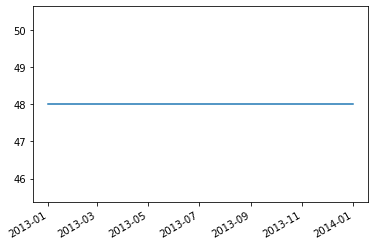

In [7]:
date_counts = smart_meter_data['Date'].value_counts()
#date_counts.plot(kind='bar')
date_counts.plot()

In [8]:
min_pwr  = np.min(smart_meter_data['KWH/hh (per half hour) '])
max_pwr  = np.max(smart_meter_data['KWH/hh (per half hour) '])

print(min_pwr, max_pwr)

0.065 2.994


In [9]:
smart_meter_data.head(10)

,DateTime,KWH/hh (per half hour),house,Date
3840,2013-01-01 00:00:00,0.219,1,2013-01-01
3841,2013-01-01 00:30:00,0.241,1,2013-01-01
3842,2013-01-01 01:00:00,0.191,1,2013-01-01
3843,2013-01-01 01:30:00,0.235,1,2013-01-01
3844,2013-01-01 02:00:00,0.182,1,2013-01-01
3845,2013-01-01 02:30:00,0.229,1,2013-01-01
3846,2013-01-01 03:00:00,0.194,1,2013-01-01
3847,2013-01-01 03:30:00,0.201,1,2013-01-01
3848,2013-01-01 04:00:00,0.122,1,2013-01-01
3849,2013-01-01 04:30:00,0.099,1,2013-01-01


In [27]:
day = smart_meter_data[smart_meter_data['Date'] == '2013-09-17']
day.shape

(48, 4)

In [28]:
day.head(len(day))

,DateTime,KWH/hh (per half hour),house,Date
16280,2013-09-17 00:00:00,0.185,1,2013-09-17
16281,2013-09-17 00:30:00,0.097,1,2013-09-17
16282,2013-09-17 01:00:00,0.133,1,2013-09-17
16283,2013-09-17 01:30:00,0.078,1,2013-09-17
16284,2013-09-17 02:00:00,0.126,1,2013-09-17
16285,2013-09-17 02:30:00,0.098,1,2013-09-17
16286,2013-09-17 03:00:00,0.105,1,2013-09-17
16287,2013-09-17 03:30:00,0.118,1,2013-09-17
16288,2013-09-17 04:00:00,0.085,1,2013-09-17
16289,2013-09-17 04:30:00,0.128,1,2013-09-17


In [29]:
smart_meter_data['Date'].value_counts()

2013-01-01    48
2013-09-09    48
2013-09-07    48
2013-09-06    48
2013-09-05    48
              ..
2013-05-01    48
2013-04-30    48
2013-04-29    48
2013-04-28    48
2013-12-31    48
Name: Date, Length: 365, dtype: int64

max =  0.074
min =  1.38


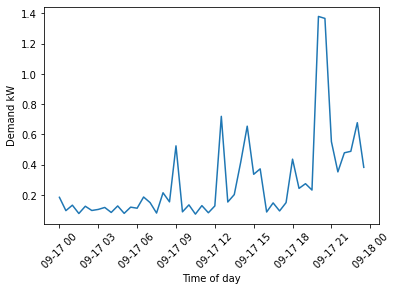

In [33]:
# show the days profile
print('max = ', np.min(day['KWH/hh (per half hour) ']))
print('min = ', np.max(day['KWH/hh (per half hour) ']))

plt.plot(day['DateTime'], day['KWH/hh (per half hour) '])


#yticks = np.arange(0, 10, 2)

#plt.ylabel('house 1 demand')
plt.ylabel('Demand kW')
plt.xlabel('Time of day')
plt.xticks(rotation = 45)
plt.show()

In [14]:
#smart_meter_data.to_csv(dirpath+'/all meters.csv')

In [15]:
# weather
weather_data = pd.read_csv(dirpath+'/GBR_London.Gatwick.037760_IWEC_copy.epw', sep='\t', 
                           usecols=['year', 'month', 'day', 'hour', 'minute', 
                                    'Global Horizontal Radiation', 'Total Sky Cover'],
                                    low_memory=False)

weather_data.head(10)

,year,month,day,hour,minute,Global Horizontal Radiation,Total Sky Cover
0,1991,1,1,1,60,0,2
1,1991,1,1,2,60,0,1
2,1991,1,1,3,60,0,0
3,1991,1,1,4,60,0,0
4,1991,1,1,5,60,0,0
5,1991,1,1,6,60,0,0
6,1991,1,1,7,60,0,1
7,1991,1,1,8,60,0,2
8,1991,1,1,9,60,19,6
9,1991,1,1,10,60,52,9


In [16]:
# weather data is hourly but smart meter data is half-hourly
# simply duplicate to half-hourly
modified_weather_data = pd.DataFrame(columns=['DateTime', 'Date', 'Global Horizontal Radiation', 'Total Sky Cover'])

for i in trange(len(weather_data)):
    
    # ignore the weather data year and match to demand file which is 2013
    new_date = '2013-' + str(weather_data.loc[i,'month']) + '-' + str(weather_data.loc[i,'day'])
    
    # weather data uses hours 1 to 24, we want 0-23, and produce on-hour and half-hour timings
    on_hr = new_date + ' ' + str(weather_data.loc[i,'hour']-1) + ':00:00'
    on_hh = new_date + ' ' + str(weather_data.loc[i,'hour']-1) + ':30:00'
    
    # convert to datetimes
    on_hr = datetime.strptime(on_hr, '%Y-%m-%d %H:%M:%S')
    on_hh = datetime.strptime(on_hh, '%Y-%m-%d %H:%M:%S')
    new_date = datetime.strptime(new_date, '%Y-%m-%d')
    
    ghr = weather_data.loc[i,'Global Horizontal Radiation']
    tsc = weather_data.loc[i,'Total Sky Cover']
    
    modified_weather_data = modified_weather_data.append({'DateTime': on_hr, 'Date': new_date, 'Global Horizontal Radiation': ghr, 'Total Sky Cover': tsc}, ignore_index=True)
    modified_weather_data = modified_weather_data.append({'DateTime': on_hh, 'Date': new_date, 'Global Horizontal Radiation': ghr, 'Total Sky Cover': tsc}, ignore_index=True)
    

100%|██████████████████████████████████████████████████████████████████████████████| 8760/8760 [02:15<00:00, 64.52it/s]


In [17]:
modified_weather_data.head(30)

,DateTime,Date,Global Horizontal Radiation,Total Sky Cover
0,2013-01-01 00:00:00,2013-01-01,0,2
1,2013-01-01 00:30:00,2013-01-01,0,2
2,2013-01-01 01:00:00,2013-01-01,0,1
3,2013-01-01 01:30:00,2013-01-01,0,1
4,2013-01-01 02:00:00,2013-01-01,0,0
5,2013-01-01 02:30:00,2013-01-01,0,0
6,2013-01-01 03:00:00,2013-01-01,0,0
7,2013-01-01 03:30:00,2013-01-01,0,0
8,2013-01-01 04:00:00,2013-01-01,0,0
9,2013-01-01 04:30:00,2013-01-01,0,0


In [18]:
modified_weather_data['Global Horizontal Radiation'].value_counts()

0      8348
1       158
3       120
4       116
2       112
       ... 
648       2
618       2
828       2
735       2
472       2
Name: Global Horizontal Radiation, Length: 781, dtype: int64

In [23]:
class SolarPV():
    
    def __init__(self, area, efficiency, performance_ratio):
        self.area = area
        self.efficiency = efficiency
        self.performance_ratio = performance_ratio
        
    def output(self, ghi):
        return np.round(ghi * self.area * self.efficiency * self.performance_ratio, 2)

In [24]:
pv = SolarPV(1.6, 0.25, 0.75)

generated = []

for i in trange(len(weather_data)):
    generated.append(pv.output(modified_weather_data.loc[i, 'Global Horizontal Radiation']))

100%|███████████████████████████████████████████████████████████████████████████| 8760/8760 [00:00<00:00, 12822.37it/s]


In [25]:
len(generated)

8760

In [26]:
generated

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.7,
 5.7,
 15.6,
 15.6,
 27.6,
 27.6,
 34.5,
 34.5,
 34.8,
 34.8,
 28.5,
 28.5,
 17.1,
 17.1,
 1.8,
 1.8,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.3,
 3.3,
 6.0,
 6.0,
 10.8,
 10.8,
 13.5,
 13.5,
 13.5,
 13.5,
 28.5,
 28.5,
 17.1,
 17.1,
 4.5,
 4.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.6,
 3.6,
 15.6,
 15.6,
 27.9,
 27.9,
 34.8,
 34.8,
 35.4,
 35.4,
 29.1,
 29.1,
 17.7,
 17.7,
 4.8,
 4.8,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.9,
